<a href="https://colab.research.google.com/github/CLmarco01/Tesina-Change-Detection/blob/main/Tesina_Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autore**: Marco Giangreco, 1938091

**Descrizione del progetto**: Risolvere il problema della binary change detection, tecnica statistica utilizzata per identificare cambiamenti o anomalie in una sequenza di dati.

Dataset di riferimento (OSCD - ONERA SATELLITE CHANGE DETECTION): https://rcdaudt.github.io/oscd/

##Google Drive

Per caricare il dataset, è possibile montare il mio Google Drive su Google Colab, consentendo così di accedere e caricare i file direttamente nell'ambiente di lavoro.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import libraries

In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable
import torchvision.transforms as tr
from torchvision.transforms import functional as F
from torch.nn.modules.padding import ReplicationPad2d  #utile per mantenere le informazioni di contorno durante l'elaborazione dell'immagine
import torch.nn.functional as F

# Other
from PIL import Image
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import warnings
from pprint import pprint

## Modello U-Net

In [ ]:
class Unet(nn.Module):
    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

##Global Variables' Definitions

In [ ]:
PATH_TO_DATASET = 'drive/MyDrive/Colab Notebooks/OSCD/Onera Satellite Change Detection dataset - Images/'

IS_PROTOTYPE = False

FP_MODIFIER = 1

BATCH_SIZE = 32 # numero di campioni
PATCH_SIDE = 96 # dimensione di una regione rettangolare all'interno di una immagine
N_EPOCHS = 10
NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

LOAD_TRAINED = False

DATA_AUG = True


print('DEFINITIONS OK')

DEFINITIONS OK


##Functions

Funzioni utilizzate per la lettura e la manipolazione
delle immagini del dataset Sentinel-2 utilizzate nell'addestramento del modello di change
detection

In [ ]:
def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""

    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape

    # pad if necessary
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])

    return np.pad(I,((0,p0),(0,p1)),'edge')


def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")

    I = np.stack((r,g,b),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    I = np.stack((r,g,b,nir),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')

    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')


    return I1, I2, cm

def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)

## Definizione del file val.txt

In [ ]:
import random

# Svuoto il file "val.txt"
with open(PATH_TO_DATASET+"val.txt", "w") as file:
    file.write("")

# Sovrascrivo il file "test_aux.txt" in "test.txt"
with open(PATH_TO_DATASET+"test_aux.txt", "r") as source:
  with open(PATH_TO_DATASET+"test.txt", "w") as destination:
    # Leggi il contenuto dal file di origine e sovrascrivi il file di destinazione
    content = source.read()
    destination.write(content)

In [ ]:
# Leggi le città dal file "test.txt"
with open(PATH_TO_DATASET+"test.txt", "r") as file:
    city_list = file.read().split(',')

# Rimuovi casualmente 5 città
random.shuffle(city_list)
val_cities = city_list[:5]
test_cities = city_list[5:]

# Aggiungi le città al file "val.txt"
with open(PATH_TO_DATASET + "val.txt", "a") as file:
    for i, city in enumerate(val_cities):
        file.write(city)
        if i != len(val_cities) - 1:
            file.write(",")

# Scrivi le città rimanenti nel file "test.txt"
with open(PATH_TO_DATASET + "test.txt", "w") as file:
    for i, city in enumerate(test_cities):
        file.write(city)
        if i != len(test_cities) - 1:
            file.write(",")

##ChangeDetectionDataset class

In [ ]:
class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, validation = False, patch_side = 96, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride

        if train:
            fname = 'train.txt'
        elif validation:
            fname = 'val.txt'
        else:
            fname = 'test.txt'

#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]

        n_pix = 0
        true_pix = 0


        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm

            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()

            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i

            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name,
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)

        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]



    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]

        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]

        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

##Dataset

In [ ]:
print("Train set")
train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE)
weights = torch.FloatTensor(train_dataset.weights).cuda()
#print(weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

print("\nTest set")
test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, validation = False, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

print("\nValidation set")
validation_dataset = ChangeDetectionDataset(PATH_TO_DATASET, validation = True, train = False, stride = TRAIN_STRIDE)
validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

print('\nDATASETS OK')

Train set


100%|██████████| 14/14 [05:57<00:00, 25.50s/it]



Test set


100%|██████████| 5/5 [02:04<00:00, 24.89s/it]



Validation set


100%|██████████| 5/5 [02:03<00:00, 24.75s/it]


DATASETS OK


##Neural Network

In [ ]:
# 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

if TYPE == 0:
     net, net_name = Unet(2*3, 2), 'FC-EF'
elif TYPE == 1:
     net, net_name = Unet(2*4, 2), 'FC-EF'
elif TYPE == 2:
     net, net_name = Unet(2*10, 2), 'FC-EF'
elif TYPE == 3:
     net, net_name = Unet(2*13, 2), 'FC-EF'

net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

NETWORK OK


##Addestramento della rete neurale

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)

    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t

    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t

    epoch_validation_loss = 0 * t
    epoch_validation_accuracy = 0 * t
    epoch_validation_change_accuracy = 0 * t
    epoch_validation_nochange_accuracy = 0 * t
    epoch_validation_precision = 0 * t
    epoch_validation_recall = 0 * t
    epoch_validation_Fmeasure = 0 * t

#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0

    lss = 1000
    best_lss = 1000

    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)


    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)


    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)


    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().cuda())
            I2 = Variable(batch['I2'].float().cuda())
            label = torch.squeeze(Variable(batch['label'].cuda()))

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()

        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]


        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        epoch_validation_loss[epoch_index], epoch_validation_accuracy[epoch_index], cl_acc, pr_rec = test(validation_dataset)
        epoch_validation_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_validation_change_accuracy[epoch_index] = cl_acc[1]
        epoch_validation_precision[epoch_index] = pr_rec[0]
        epoch_validation_recall[epoch_index] = pr_rec[1]
        epoch_validation_Fmeasure[epoch_index] = pr_rec[2]


        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        l1_3, = plt.plot(t[:epoch_index + 1], epoch_validation_loss[:epoch_index + 1], label='Validation loss')
        plt.legend(handles=[l1_1, l1_2, l1_3])
        plt.grid()
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        l2_3, = plt.plot(t[:epoch_index + 1], epoch_validation_accuracy[:epoch_index + 1], label='Validation accuracy')
        plt.legend(handles=[l2_1, l2_2, l2_3])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        l3_5, = plt.plot(t[:epoch_index + 1], epoch_validation_nochange_accuracy[:epoch_index + 1], label='Validation accuracy: no change')
        l3_6, = plt.plot(t[:epoch_index + 1], epoch_validation_change_accuracy[:epoch_index + 1], label='Validation accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4, l3_5, l3_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        l4_7, = plt.plot(t[:epoch_index + 1], epoch_validation_precision[:epoch_index + 1], label='Validation precision')
        l4_8, = plt.plot(t[:epoch_index + 1], epoch_validation_recall[:epoch_index + 1], label='Validation recall')
        l4_9, = plt.plot(t[:epoch_index + 1], epoch_validation_Fmeasure[:epoch_index + 1], label='Validation Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6, l4_7, l4_8, l4_9])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())


#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)


#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)

        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)


#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)

    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1],
           'validation_accuracy': epoch_validation_accuracy[-1],
           'validation_nochange_accuracy': epoch_validation_nochange_accuracy[-1],
           'validation_change_accuracy': epoch_validation_change_accuracy[-1]}

    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)

    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape


        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()


                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]

    return net_loss, net_accuracy, class_accuracy, pr_rec

Number of trainable parameters: 1353458


##Addestramento del modello

###Caricamento del modello

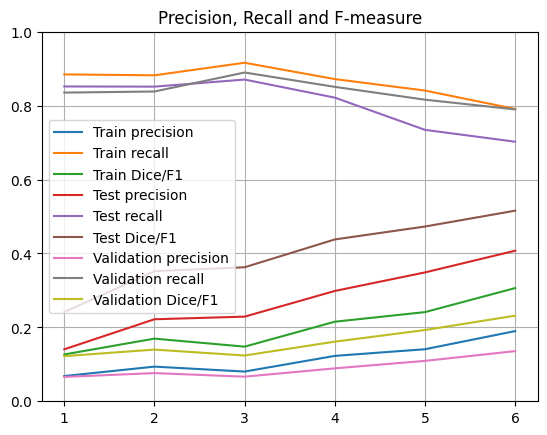

 60%|██████    | 6/10 [55:59<37:05, 556.46s/it]

Epoch: 7 of 10


In [ ]:
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)

if not LOAD_TRAINED:
    torch.save(net.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

###Funzione save test

In [ ]:
def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
            I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            io.imsave(f'{net_name}-{name}.png',I)

###Valutazione del test

In [ ]:
t_start = time.time()
save_test_results(train_dataset)
save_test_results(test_dataset)
save_test_results(validation_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))

L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)

    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape

        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()

                output = net(I1, I2)

                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, dice, prec_nc, rec_nc]

    k = kappa(tp, tn, fp, fn)

    return {'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'class_accuracy': class_accuracy,
            'precision': prec,
            'recall': rec,
            'dice': dice,
            'kappa': k}

results = test(test_dataset)
pprint(results)

  0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-13-6ecd1eaa1b7d>:10: UserWarning: FC-EF-aguasclaras.png is a low contrast image
  io.imsave(f'{net_name}-{name}.png',I)
  7%|▋         | 1/14 [00:01<00:23,  1.78s/it]<ipython-input-13-6ecd1eaa1b7d>:10: UserWarning: FC-EF-bercy.png is a low contrast image
  io.imsave(f'{net_name}-{name}.png',I)
 14%|█▍        | 2/14 [00:01<00:10,  1.18it/s]<ipython-input-13-6ecd1eaa1b7d>:10: UserWarning: FC-EF-bordeaux.png is a low contrast image
  io.imsave(f'{net_name}-{name}.png',I)
 21%|██▏       | 3/14 [00:02<00:05,  1.92it/s]<ipython-input-13-6ecd1eaa1b7d>:10: UserWarning: FC-EF-nantes.png is a low contrast image
  io.imsave(f'{net_name}-{name}.png',I)
 29%|██▊       | 4/14 [00:02<00:04,  2.02it/s]<ipython-input-13-6ecd1eaa1b7d>:10: UserWarning: FC-EF-paris.png is a low contrast image
  io.imsave(f'{net_name}-{name}.png',I)
 36%|███▌      | 5/14 [00:02<00:03,  2.60it/s]<ipython-input-13-6ecd1eaa1b7d>:10: UserWarning: FC-EF-rennes.png is a low co

Elapsed time: 8.86289930343628


100%|██████████| 5/5 [00:49<00:00,  9.92s/it]

{'class_accuracy': [99.81854248046875, 0.10994097590446472],
 'dice': 0.0021476408918361385,
 'kappa': -0.0012982731703855385,
 'net_accuracy': 92.4472408384429,
 'net_loss': 1.11319100856781,
 'precision': 0.04613516794819911,
 'recall': 0.001099409790533503}
